## Estimation of activity levels: Part II

This section explains how `activity` is estimated for intermittent (lumpy, volatile, and/or unpredictable) energy consumption.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from eensight.methods.prediction.baseline import UsagePredictor
from eensight.methods.prediction.activity import estimate_activity
from eensight.methods.prediction.metrics import cvrmse, nmbe
from eensight.utils import load_catalog

plt.style.use("bmh")

%matplotlib inline

### The *b04* dataset

The *b04* data corresponds to the whole building gas meter consumption from the [AMPds2 Dataset](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/FIE0S4). 

In [3]:
catalog_train = load_catalog(store_uri="../../../data", site_id="b04", namespace="train")

X_train = catalog_train.load("train.preprocessed-features")
y_train = catalog_train.load("train.preprocessed-labels")

The following plot presents the energy consumption of the selected dataset as a function of the outdoor temperature:

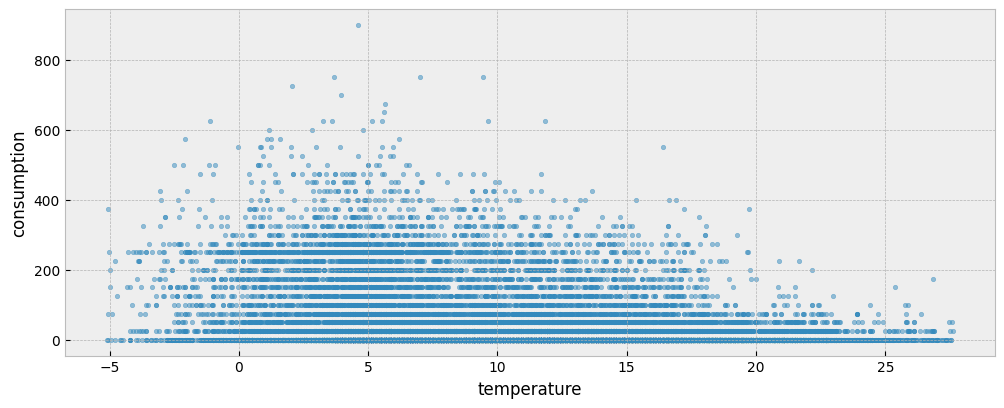

In [4]:
fig = plt.figure(figsize=(12, 4.5))
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

ax.scatter(X_train["temperature"], y_train["consumption"], s=10, alpha=0.5)
ax.set_xlabel("temperature")
ax.set_ylabel("consumption")

### The `predict` pipeline

**When run in the `train` namespace**

Fit a predictive model on the `train` data:

In [5]:
model = UsagePredictor().fit(X_train, y_train)

**When run in the `test` namespace**

Load `test` data:

In [6]:
catalog_test = load_catalog(store_uri="../../../data", site_id="b04", namespace="test")

X_test = catalog_test.load("test.preprocessed-features")
y_test = catalog_test.load("test.preprocessed-labels")

Both the `train` and `test` period consumption data are presented in the next plot:

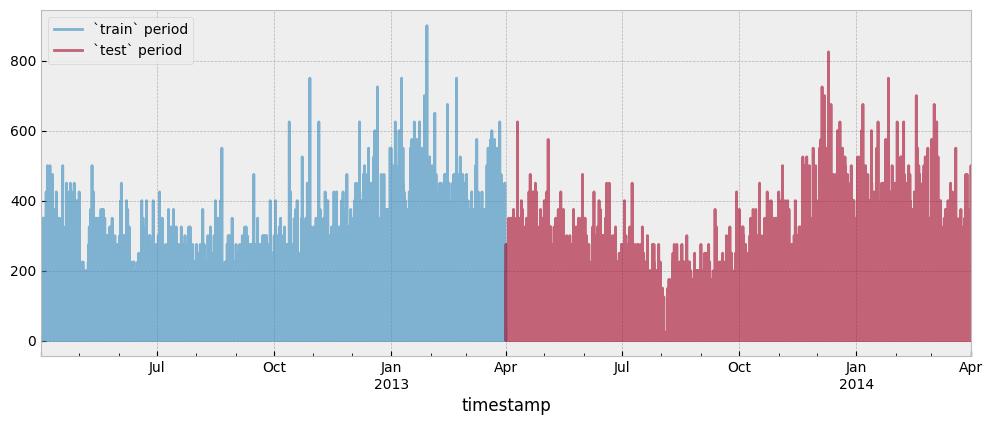

In [7]:
fig = plt.figure(figsize=(12, 4.5))
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

y_train.plot(ax=ax, alpha=0.6)
y_test.plot(ax=ax, alpha=0.6)

ax.legend(["`train` period", "`test` period"], frameon=True)

Evaluate the model on the `test` data:

In [8]:
prediction = model.predict(X_test)
cvrmse(y_test, prediction)

1.8421000874816855

This is a very high error that is caused by the randomness of the daily energy consumption profiles:

In [9]:
y_train_daily = y_train.copy()
y_train_daily["date"] = y_train_daily.index.date
y_train_daily["time"] = y_train_daily.index.time

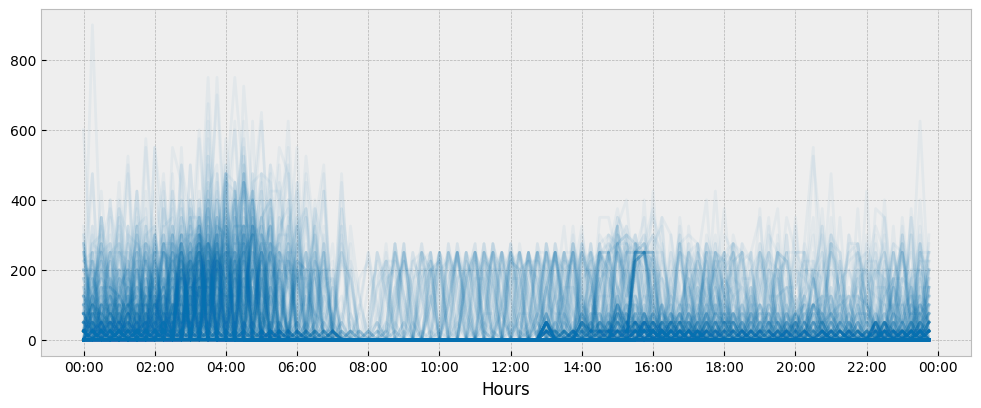

In [10]:
fig = plt.figure(figsize=(12, 4.5))
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

y_train_daily.pivot(index='time', columns='date', values='consumption') \
             .plot(ax=ax, alpha=0.05, legend=None, color='#0570b0')

ax.xaxis.set_major_locator(ticker.MultipleLocator(3600*2))
ax.set_xlabel('Hours')

The main difficulty in predicting intermittent energy consumption is that we cannot easily predict **when** it is going to be larger than zero. 

Since this dataset corresponds to residential gas consumption, it contains a significant number of zero values:

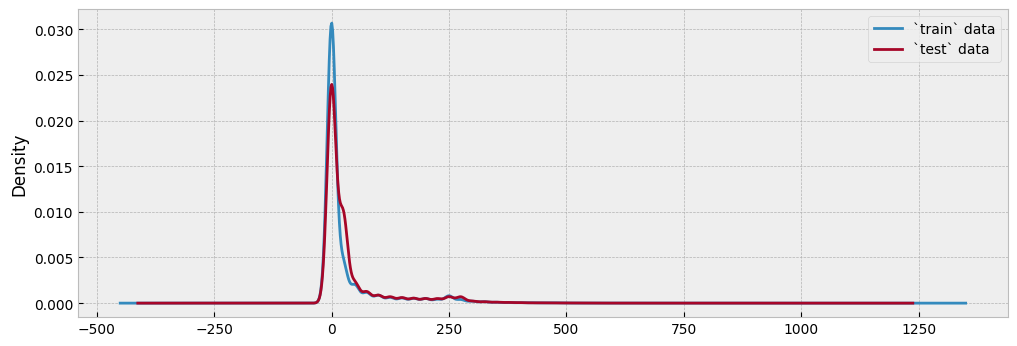

In [11]:
fig = plt.figure(figsize=(12, 4))
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

y_train.plot.kde(ax=ax)
y_test.plot.kde(ax=ax)

ax.legend(["`train` data", "`test` data"], frameon=True)

If we move away from the idea of predicting energy consumption and towards the idea of, first, mapping conditions and, then, comparing samples of similar conditions, we can select only the observations with non-zero energy consumption values. 

First, fit a predictive model using only the observations with non-zero energy consumption values for the `train` period:

In [12]:
y_train_on = y_train[y_train["consumption"] > 1e-05]
X_train_on = X_train.loc[y_train_on.index]

model = UsagePredictor().fit(X_train_on, y_train_on)

Then, apply the model on only the observations with non-zero energy consumption values for the `test` period:

In [13]:
y_test_on = y_test[y_test["consumption"] > 1e-05]
X_test_on = X_test.loc[y_test_on.index]

prediction = model.predict(X_test_on)
cvrmse(y_test_on, prediction)

1.0874032363103652

The error is now lower, but still quite high.

### The `predict` pipeline with autoencoding

**When run in the `train` namespace**

Estimate activity levels. This time we will set the argument `assume_hurdle` to `True`. If `True`, it is assumed that the energy consumption data is generated from a hurdle model. A hurdle model is a two-part model that specifies one process for zero values and another process for the positive ones.

In [14]:
for feature in X_train.columns:
    print(feature)

temperature
dew point temperature


In [15]:
non_occ_features = ["temperature", "dew point temperature"]

act_train = estimate_activity(
    X_train, 
    y_train, 
    non_occ_features=non_occ_features, 
    exog="temperature",
    assume_hurdle=True,

)

The next plot shows the estimated activity levels along with the actual energy consumption for the first day of January during the `train` period:

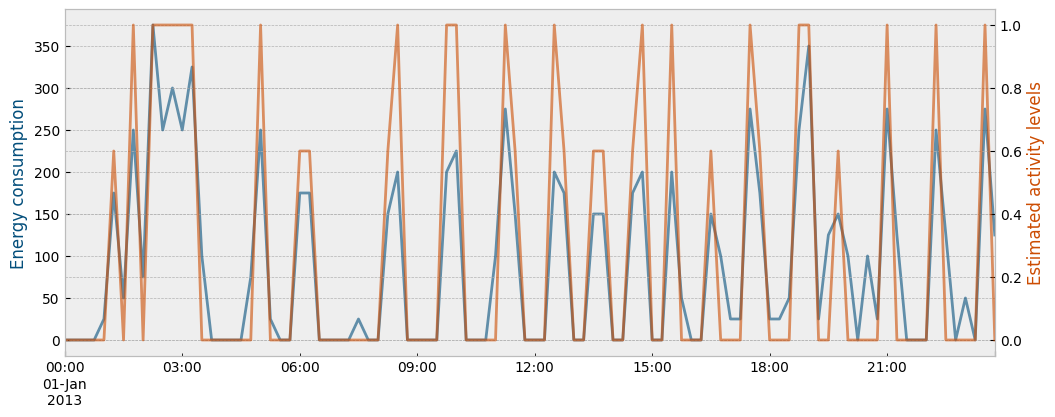

In [16]:
month = 1 # January
n_obs = 24*4

fig = plt.figure(figsize=(12, 4.5))
layout = (1, 1)
ax1 = plt.subplot2grid(layout, (0, 0))
ax2 = ax1.twinx()

y_train["consumption"].loc[y_train.index.month==month][:n_obs].plot(
    ax=ax1, color="#034e7b", alpha=0.6
)
act_train.loc[act_train.index.month==month][:n_obs].plot(
    ax=ax2, color="#cc4c02", alpha=0.6
)

ax1.set_ylabel("Energy consumption", color="#034e7b")
ax2.set_ylabel("Estimated activity levels", color="#cc4c02")

Use the estimated activity levels as features and fit a predictive model for energy consumption given the estimated activity and the weather data in the `train` period:

In [17]:
X_train_act = pd.concat(
    [
        X_train,
        act_train.to_frame("activity")
    ],
    axis=1
)

model = UsagePredictor(skip_calendar=True).fit(X_train_act, y_train)

**When run in the `test` namespace**

Estimate activity levels:

In [18]:
act_test = estimate_activity(
    X_test, 
    y_test, 
    non_occ_features=non_occ_features, 
    exog="temperature",
    assume_hurdle=True
)

Apply the predictive model:

In [19]:
X_test_act = pd.concat(
    [
        X_test,
        act_test.to_frame("activity")
    ], 
    axis=1
)

prediction = model.predict(X_test_act)

The new CV(RMSE) is:

In [21]:
cvrmse(y_test, prediction)

0.7448453092317262

We got a better result this time. However, we now have something even more important: an estimation for the activity levels. 

We will argue that estimating the impact during the highest activity levels is the most important task, since the corresponding subset is the one we care about when evaluating the impact of an energy retrofit that upgrades the building's envelope or the efficiency of the heating system. These observations are a small part of the whole dataset, but the most informative one:

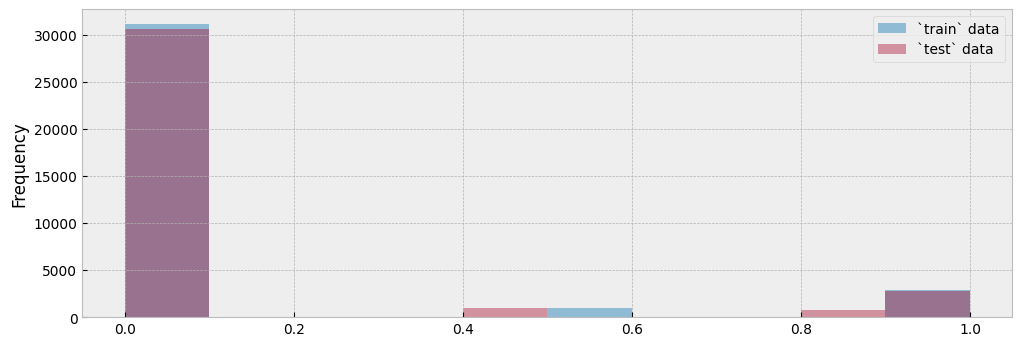

In [22]:
fig = plt.figure(figsize=(12, 4))
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

act_train.plot.hist(bins=10, ax=ax, alpha=0.5)
act_test.plot.hist(bins=10, ax=ax, alpha=0.4)

ax.legend(["`train` data", "`test` data"], frameon=True)

Let's isolate all `train` and `test` observations where activity equals one (1):

In [23]:
y_train_selected = y_train[act_train == 1]
X_train_selected = X_train.loc[y_train_selected.index]

y_test_selected = y_test[act_test == 1]
X_test_selected = X_test.loc[y_test_selected.index]

We can plot the two subsets side by side:

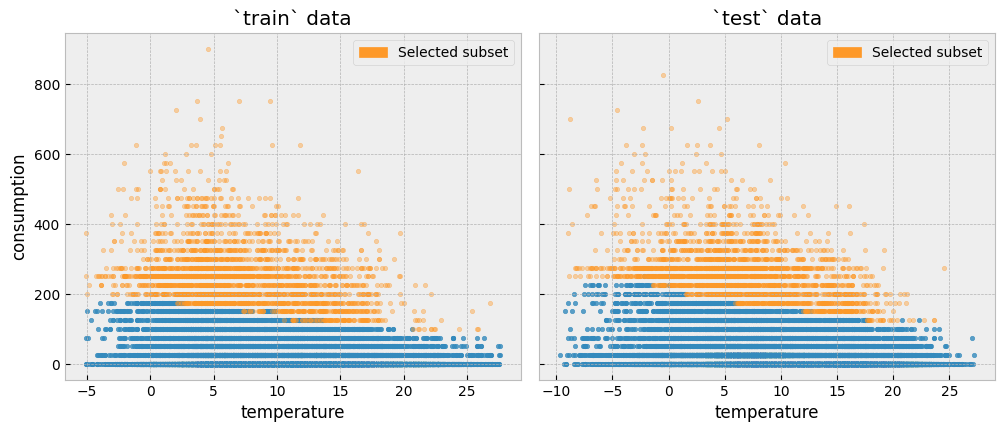

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4.5))
fig.subplots_adjust(wspace=0.04)

ax1.scatter(
    X_train.loc[~X_train.index.isin(X_train_selected.index), "temperature"], 
    y_train.loc[~y_train.index.isin(y_train_selected.index), "consumption"], 
    s=10, 
    alpha=0.8
)

ax1.scatter(
    X_train_selected["temperature"], 
    y_train_selected["consumption"], 
    s=10, 
    alpha=0.4,
    color="#fe9929"
)

ax1.set_xlabel("temperature")
ax1.set_ylabel("consumption")
ax1.set_title("`train` data")

ax1.legend(
    handles=[
        mpatches.Patch(color="#fe9929", label="Selected subset"), 
    ]
)

ax2.scatter(
    X_test.loc[~X_test.index.isin(X_test_selected.index), "temperature"], 
    y_test.loc[~y_test.index.isin(y_test_selected.index), "consumption"],
    s=10, 
    alpha=0.8
)

ax2.scatter(
    X_test_selected["temperature"], 
    y_test_selected["consumption"], 
    s=10, 
    alpha=0.4,
    color="#fe9929"
)

ax2.set_xlabel("temperature")
ax2.set_title("`test` data")

ax2.legend(
    handles=[
        mpatches.Patch(color="#fe9929", label="Selected subset"), 
    ]
)

The plot below shows the distributions of the energy consumption values for the `train` and `test` data, and for all observations with the highest activity levels. Since there has been no event that alters the energy consumption between the two periods, the distributions should be similar:

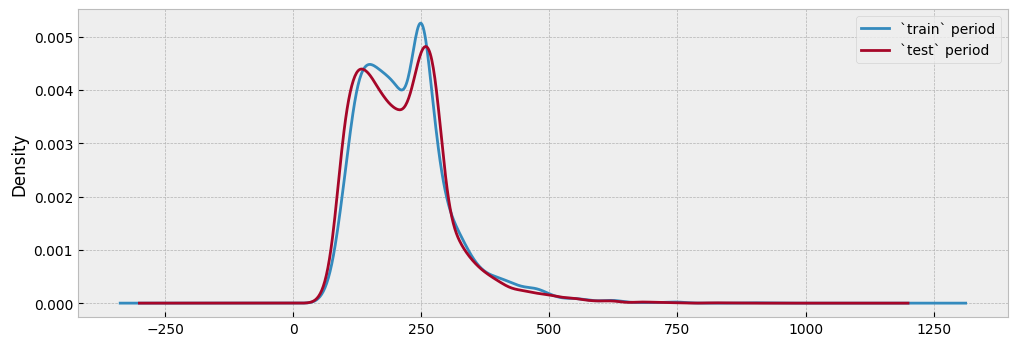

In [25]:
fig = plt.figure(figsize=(12, 4))
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

y_train.loc[act_train[act_train >0].index].plot.kde(ax=ax)
y_test.loc[act_test[act_test >0].index].plot.kde(ax=ax)

ax.legend(["`train` period", "`test` period"], frameon=True)

Fit a predictive model only on the highest activity observations in the `train` data:

In [26]:
X_train_cond = pd.concat(
    [
        X_train.loc[y_train_selected.index],
        act_train.loc[y_train_selected.index].to_frame("activity")
        
    ], 
    axis=1
)

model = UsagePredictor(skip_calendar=True).fit(X_train_cond, y_train_selected)

Then, map the corresponding activity observations in the `test` data: 

In [27]:
X_test_cond = pd.concat(
    [
        X_test.loc[y_test_selected.index],
        act_test.loc[y_test_selected.index].to_frame("activity")
    ], 
    axis=1
)

prediction = model.predict(X_test_cond)

Evaluate the results:

In [28]:
cvrmse(y_test_selected, prediction)

0.2857649421730923

This is a good enough accuracy to apply M&V. A possible strategy for intermittent demand data - and the one that `eensight` employs - is to estimate the impact of an intervention using the observations with the highest activity levels and, then, interpolate the impact over the remaining observations (assuming zero impact for zero activity).  

Even if we were concerned that the autoencoding method may not be able to avoid overfitting for intermittent demand data, we could use the predicted activity levels to find the most informative subset of the data and, then, fit a predictive model directly to that subset.

First, fit a predictive model on all `train` observations with the highest activility levels:

In [29]:
model = UsagePredictor().fit(X_train_selected, y_train_selected)

Then, apply the model on all `test` observations with the highest activility levels:

In [30]:
prediction = model.predict(X_test_selected)

The CV(RMSE) is similar to the autoencoding approach (so no much reason to be concerned for possible overfitting):

In [31]:
cvrmse(y_test_selected, prediction)

0.2733409295170134

This is exactly what is done when the `predict` and `evaluate` pipelines are called while setting the `activity.assume_hardle` parameter to true. In particular:

* When the `predict` pipeline is called from the command line as:

 ```bash
 eensight run predict --site-id b04 --store-uri ../../../data --namespace train --autoencode --param activity.assume_hurdle=true
 ```

 the `UsagePredictor` model is trained only on the subset where `activity = 1`.



* When the `predict` pipeline is called from the command line as:

 ```bash
 eensight run predict --site-id b04 --store-uri ../../../data --namespace test --autoencode --param activity.assume_hurdle=true
 ```

 the generated prediction does not use the `activity` feature at all (it has already be used to select the training subset)


* When the `evaluate` pipeline is called from the command line as:

 ```bash
 eensight run evaluate --site-id b04 --store-uri ../../../data --namespace test --autoencode --param activity.assume_hurdle=true
 ```

 the performance of the `model-autoenc` is evaluated only on the `test` subset with `activity = 1`.


* When the `evaluate` pipeline is called from the command line as:

 ```bash
 eensight run evaluate --site-id b04 --store-uri ../../../data --namespace apply --autoencode --param activity.assume_hurdle=true
  ```
  
  the estimated impact is multiplied by the activity levels: zero (0) activity levels mean zero impact, activity levels of one (1) mean that the impact estimation remains intact, and in all other cases, impact is scaled down proportionally to the activity.

---------------------------